In [1]:
# dependency
import numpy as np
import pandas as pd
import copy
import math
import sys
import os
from activations import relu, leaky_relu, sigmoid, tanh, softmax, d_sigmoid, d_relu
from initializers import glorot_uniform, random_normal, random_uniform
from regularizers import l1_regularizer, l2_regularizer
from utility import trim_tail, multiply, subtract, get_nparams, one_hot_encoding, get_data
from metrics import MSE, CCE, ACC, PRECISION, RECALL, essential_metrics, wondering_penalty, close_gap_penalty
from pso import PSO
from ga import GA
from nn import Network
from layer import DenseLayer
from scalers import MinMaxScaler, StandardScaler

In [2]:
# reference
metrics_fn_dict = dict()
metrics_fn_dict['accuracy'] = ACC
metrics_fn_dict['categorical_crossentropy'] = CCE
metrics_fn_dict['mean_square_error'] = MSE
metrics_fn_dict['precision'] = PRECISION
metrics_fn_dict['recall'] = RECALL
metrics_fn_dict['essential_metrics'] = essential_metrics

In [3]:
# model
model = Network(5, lr = None)
model.add_layer(DenseLayer(1, 4, True, afn=sigmoid, dafn=None, rfn=None))
model.add_layer(DenseLayer(2, 3, True, afn=softmax, dafn=None, rfn=None))

In [4]:
# optimizer
ga = GA(
    dict(
        m = 75,
        x_rate = 0.5,
        m_rate = 0.6,
        weight_constraint = [-3.,3.],
        radioactive_rating = 0.5,
        grow_factor = 0.5,
        scale_hyperparameter = False))

In [5]:
model.compile(loss_fn = 'categorical_crossentropy', optimizer = ga, \
    metrics = ['accuracy', 'mean_square_error', 'categorical_crossentropy', 'precision', 'recall', 'f1'])

building layer 1 with 5
24
building layer 2 with 4
15


In [6]:
# data loading
DATA = os.path.join('c:\\Users\\tcumi\\github_repo\\neural-network\\', 'dataset')
GROUP = 3
COLUMNS = ['f1', 'f2', 'f3', 'f4', 'f5', 'label']
N_CLASS = 3
EPOCHS = 500
train_dir, test_dir = "..//dataset//training_data{}.txt".format(GROUP), "..//dataset//testing_data{}.txt".format(GROUP)
train, test = get_data(DATA, train_dir, COLUMNS), get_data(DATA, test_dir, COLUMNS)
# shuffle
train, test = train.sample(frac=1), test.sample(frac=1)
x_train, y_train = train.drop('label', axis=1), train['label']
x_test, y_test = test.drop('label', axis=1), test['label']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107 entries, 0 to 106
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   f1      107 non-null    float32
 1   f2      107 non-null    float32
 2   f3      107 non-null    float32
 3   f4      107 non-null    float32
 4   f5      107 non-null    float32
 5   label   107 non-null    float32
dtypes: float32(6)
memory usage: 2.6 KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108 entries, 0 to 107
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   f1      108 non-null    float32
 1   f2      108 non-null    float32
 2   f3      108 non-null    float32
 3   f4      108 non-null    float32
 4   f5      108 non-null    float32
 5   label   108 non-null    float32
dtypes: float32(6)
memory usage: 2.7 KB
None


In [7]:
# data scaling and encoding
scaler = StandardScaler(['f1', 'f2', 'f3', 'f4', 'f5'])
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)
y_train = one_hot_encoding(y_train, N_CLASS)
y_test = one_hot_encoding(y_test, N_CLASS)

In [8]:
# learning phase
breakpoint = 100
checkpoints = list()
history = list()
for century in range(0, EPOCHS, breakpoint):
    sub_history = model.fit(x_train, y_train, breakpoint, verbose = 0)
    score = model.evaluate(x_test, y_test, False, verbose = 0)
    print('Checkpoint {}, Accuracy: {}, Loss: {}'.format(century+breakpoint, score['accuracy'], score[model.loss_fn]))
    score['checkpoint'] = century + breakpoint
    checkpoints.append(score)
    history.extend(sub_history)

C:\Users\tcumi\github_repo\neural-network\python\ga.py:189: RuntimeWarning: overflow encountered in add
  self.population.sort(key=lambda p: p.fitness + np.random.uniform(-shift, shift, 1), reverse = self.aim)


Checkpoint 100, Accuracy: 0.8395061728395061, Loss: 0.6622365315755209
Checkpoint 200, Accuracy: 0.8395061728395061, Loss: 0.6550649007161459
Checkpoint 300, Accuracy: 0.8395061728395061, Loss: 0.6547232027407046
Checkpoint 400, Accuracy: 0.8395061728395061, Loss: 0.647814291494864
Checkpoint 500, Accuracy: 0.8395061728395061, Loss: 0.6526059751157407


In [9]:
import matplotlib.pyplot as plt

def draw_plot(x, y_list, x_label=None, y_label=None, legend=None):
    fig, ax = plt.subplots(figsize=(12,5))
    for y in y_list:
        ax.plot(x, y)
    if x_label is not None and y_label is not None:
        title = '{} VS {}'.format(x_label, y_label)
        ax.set(xlabel=x_label, ylabel=y_label, title=title)
    if legend is not None:
        ax.legend(legend)
    ax.grid()
    plt.show()

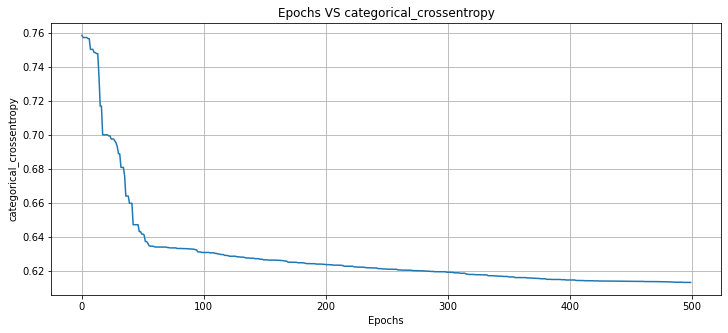

In [10]:
draw_plot(x = [i for i in range(len(history))], y_list = [history], x_label = 'Epochs', \
    y_label = model.loss_fn)

In [11]:
# recall phase
score = model.evaluate(x_test, y_test, False)
print(score)

[1. 0. 0.] <-> [[0.90534204]
 [0.05934694]
 [0.03531097]]
[1. 0. 0.] <-> [[0.6012156 ]
 [0.27812362]
 [0.12066077]]
[1. 0. 0.] <-> [[0.9060212]
 [0.0593144]
 [0.0346645]]
[0. 0. 1.] <-> [[0.8051885 ]
 [0.1548302 ]
 [0.03998135]]
[1. 0. 0.] <-> [[0.89017946]
 [0.06447013]
 [0.04535049]]
[1. 0. 0.] <-> [[0.7566298 ]
 [0.19162306]
 [0.05174711]]
[1. 0. 0.] <-> [[0.9127045 ]
 [0.05916381]
 [0.02813161]]
[1. 0. 0.] <-> [[0.9055213 ]
 [0.05933801]
 [0.03514075]]
[1. 0. 0.] <-> [[0.8845616 ]
 [0.07234497]
 [0.04309338]]
[1. 0. 0.] <-> [[0.9040022 ]
 [0.05942285]
 [0.03657492]]
[0. 1. 0.] <-> [[0.37248412]
 [0.37252596]
 [0.25498992]]
[0. 0. 1.] <-> [[0.7073584 ]
 [0.22343977]
 [0.0692018 ]]
[1. 0. 0.] <-> [[0.5816726 ]
 [0.28720644]
 [0.131121  ]]
[0. 1. 0.] <-> [[0.3842922 ]
 [0.3685481 ]
 [0.24715975]]
[1. 0. 0.] <-> [[0.5819452 ]
 [0.28708047]
 [0.1309744 ]]
[1. 0. 0.] <-> [[0.9006203 ]
 [0.05970368]
 [0.03967611]]
[1. 0. 0.] <-> [[0.8865278 ]
 [0.06940036]
 [0.04407186]]
[0. 0. 1.] <-> [[

In [12]:
# Testing Performance

In [13]:
for checkpoint in checkpoints:
    print(checkpoint, '\n\n')

{'accuracy': 0.8395061728395061, 'mean_square_error': 2.973075537076037, 'categorical_crossentropy': 0.6622365315755209, 'precision': 0.7592592592592593, 'recall': 0.7592592592592593, 'f1': 0.7592592592592593, 'essential_metrics': {0: {'tp_hit': 76, 'fp_hit': 19, 'tn_hit': 11, 'fn_hit': 2}, 1: {'tp_hit': 3, 'fp_hit': 3, 'tn_hit': 89, 'fn_hit': 13}, 2: {'tp_hit': 3, 'fp_hit': 4, 'tn_hit': 90, 'fn_hit': 11}}, 'checkpoint': 100} 


{'accuracy': 0.8395061728395061, 'mean_square_error': 2.969298949578649, 'categorical_crossentropy': 0.6550649007161459, 'precision': 0.7592592592592593, 'recall': 0.7592592592592593, 'f1': 0.7592592592592593, 'essential_metrics': {0: {'tp_hit': 77, 'fp_hit': 21, 'tn_hit': 9, 'fn_hit': 1}, 1: {'tp_hit': 2, 'fp_hit': 1, 'tn_hit': 91, 'fn_hit': 14}, 2: {'tp_hit': 3, 'fp_hit': 4, 'tn_hit': 90, 'fn_hit': 11}}, 'checkpoint': 200} 


{'accuracy': 0.8395061728395061, 'mean_square_error': 2.9729417345878346, 'categorical_crossentropy': 0.6547232027407046, 'precision': 

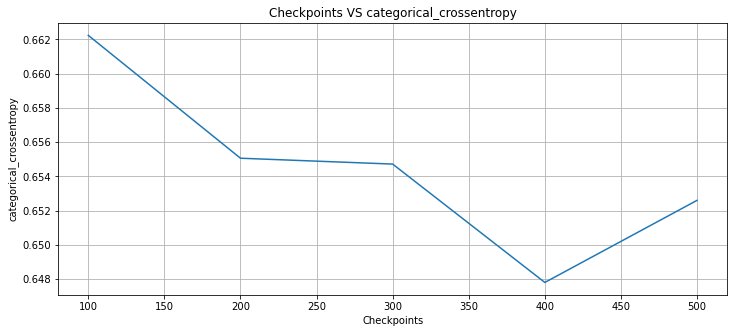

In [14]:
cat_cross = [ ckp[model.loss_fn] for ckp in checkpoints ]
draw_plot(x = [(i+1)*breakpoint for i in range(len(checkpoints))], y_list = [cat_cross], x_label = 'Checkpoints', \
    y_label = model.loss_fn)

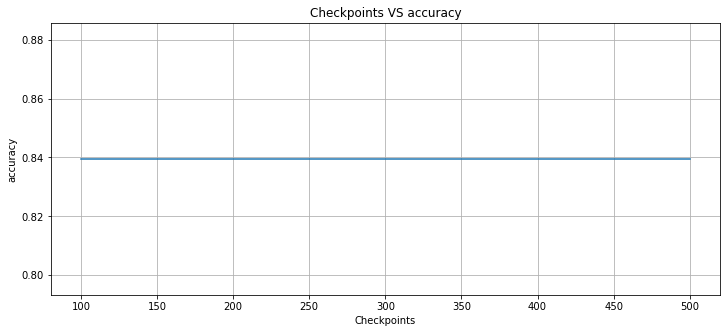

In [15]:
acc = [ ckp['accuracy'] for ckp in checkpoints ]
draw_plot(x = [(i+1)*breakpoint for i in range(len(checkpoints))], y_list = [acc], x_label = 'Checkpoints', \
    y_label = 'accuracy')

In [16]:
print(model)

Layer 1
Neuron 0: weights:
[[2.0757582]
 [1.7515309]
 [1.4069866]
 [1.1054158]
 [3.       ]]
 bias: [1.9194236]

Neuron 1: weights:
[[1.0737836]
 [0.3784411]
 [3.       ]
 [2.0819774]
 [1.3912874]]
 bias: [3.]

Neuron 2: weights:
[[ 0.15323438]
 [-1.2929945 ]
 [-1.1930298 ]
 [ 2.0053527 ]
 [-1.2930635 ]]
 bias: [3.]

Neuron 3: weights:
[[-0.3673903 ]
 [-1.1279283 ]
 [ 0.81860715]
 [-1.065272  ]
 [ 1.3737187 ]]
 bias: [0.06010365]

$
Layer 2
Neuron 0: weights:
[[-0.58051807]
 [-0.2589156 ]
 [ 3.        ]
 [ 1.4916276 ]]
 bias: [-1.7527335]

Neuron 1: weights:
[[-0.04031012]
 [ 0.79083514]
 [-0.303155  ]
 [ 1.4406208 ]]
 bias: [-1.1514522]

Neuron 2: weights:
[[ 1.410566 ]
 [-1.7594022]
 [-1.0779332]
 [-2.0506063]]
 bias: [1.418044]

$

